<a href="https://colab.research.google.com/github/Otavio8888/macroeconometric/blob/selic_breakdown/choque_juro_renda_bens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Choque de juros e renda em bens duráveis e não duráveis

## Introdução

A compreensão da dinâmica do consumo das famílias é um elemento central para a análise macroeconômica e para a formulação de política monetária. O consumo agregado, no entanto, não é um bloco monolítico; sua decomposição entre bens duráveis e não duráveis revela sensibilidades distintas aos ciclos econômicos e às condições financeiras. Bens duráveis, como veículos e eletrodomésticos, representam decisões de investimento intertemporais, sendo altamente sensíveis às taxas de juros e às expectativas de renda futura. Em contrapartida, o consumo de bens não duráveis, como alimentos e medicamentos, está mais associado à renda corrente e exibe menor volatilidade.

Este estudo utiliza o ferramental econométrico de Vetores Autorregressivos (VAR) para investigar e quantificar essas dinâmicas na economia brasileira.

A análise demonstra o poder do ecossistema Python, que permite a execução de um ciclo completo de análise de dados: desde a coleta automatizada de séries em múltiplas fontes (IBGE e Banco Central), passando pelo tratamento e transformação dos dados, até a estimação de modelos econométricos avançados e a visualização de seus resultados através de funções de impulso-resposta.

## Objetivo

O objetivo principal deste trabalho é mensurar e comparar as respostas dinâmicas do consumo de bens duráveis e não duráveis a choques exógenos na taxa de juros real e na renda disponível das famílias no Brasil. A análise busca validar empiricamente a teoria de que o consumo de duráveis é o principal canal através do qual a política monetária impacta a demanda agregada no curto e médio prazo.

O exercício tem como referência o Boxe "[Juros, renda e o consumo de duráveis e não duráveis](https://www.bcb.gov.br/content/ri/relatorioinflacao/202412/ri202412b3p.pdf)" do Relatório de Inflação de Dezembro de 2024. Há ligeiras mudanças neste exercício proposto, obtendo resultados númericos diferentes comparado ao do BCB, mas com a mesma conclusão.

## Metodologia e Dados

Para alcançar o objetivo proposto, foram coletadas séries temporais mensais, posteriormente agregadas para uma frequência trimestral, a fim de suavizar a volatilidade e alinhar a análise com a periodicidade de variáveis como o PIB. As fontes de dados foram o Sistema Gerenciador de Séries Temporais (SGS) do Banco Central e o SIDRA do IBGE, integrados via bibliotecas `python-bcb` e `sidrapy`.

As variáveis endógenas do modelo são:
1.  **Taxa de Juros Real Ex-Post:** Calculada a partir da taxa Selic nominal, descontada pela inflação acumulada em 12 meses (IPCA), conforme a equação de Fisher.
2.  **Renda Disponível das Famílias:** Utilizou-se a Renda Nacional Disponível Bruta das Famílias (RNDBF Restrita), deflacionada pelo IPCA.
3.  **Consumo de Bens Não Duráveis:** Agregação dos índices de volume de vendas da Pesquisa Mensal de Comércio (PMC) para categorias como combustíveis, hipermercados, vestuário e produtos farmacêuticos.
4.  **Consumo de Bens Duráveis:** Agregação dos índices de volume de vendas da PMC para categorias como móveis, eletrodomésticos, equipamentos de informática e veículos.

Para a estimação do modelo VAR, as séries foram transformadas para garantir a estacionariedade, um pré-requisito técnico. A taxa de juros real foi utilizada em primeira diferença, enquanto as demais variáveis foram transformadas em logaritmo e, subsequentemente, em primeira diferença, aproximando suas taxas de crescimento trimestrais. Adicionalmente, uma variável *dummy* foi incluída como variável exógena para controlar o efeito atípico da pandemia de COVID-19 nos dados mais recentes, embora o foco da análise seja o período anterior.

O modelo econométrico é um **Vetor Autorregressivo (VAR)**, que permite analisar a interdependência dinâmica entre as variáveis sem impor restrições teóricas fortes. A ordem de defasagem do modelo foi selecionada automaticamente com base no Critério de Informação Bayesiano (BIC).

A principal ferramenta de análise são as **Funções de Impulso-Resposta (IRF)**, que rastreiam o efeito de um choque não antecipado de um desvio-padrão em uma variável sobre as demais variáveis do sistema ao longo do tempo.

## Bibliotecas

In [ ]:
!pip install python-bcb --quiet
!pip install sidrapy --quiet
import pandas as pd
import numpy as np
from bcb import Expectativas, sgs
import sidrapy as sidra
from statsmodels.tsa.api import VAR
from plotnine import *
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Paleta de cores personalizada
cores_am = ["#282f6b", "#1B998B", "#FF7A00", "#00798C", "#b22200",
            "#50514F", "#003366", "#eace3f", "#005A9C", "#808080", "#2E294E"]

# Configurar estilo geral do gráfico
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13

## Coleta de dados

## PMC Duráveis

In [ ]:
# Tabela 8883: Índice do volume de vendas no comércio varejista ampliado
# Variável 7170: Número-índice com ajuste sazonal (2022=100)
# Classificação 85: Tipos de produtos
#   - Bens Duráveis: móveis e eletrodomésticos (2759), equipamentos de informática (2762),
#                    material de construção (103157), veículos e peças (103159)
# /t/8883/n1/all/v/7170/p/all/c11046/56736/c85/2759,2762,103157,103159/d/v7170%205
pmc_duraveis_raw = sidra.get_table(
    table_code='8883',
    territorial_level='1',
    ibge_territorial_code='all',
    variable='7170',
    period='all',
    classifications={
        '11046': '56736',  # PMC - Número-índice com ajuste sazonal
        '85': '2759,2762,103157,103159'  # Categorias de bens duráveis
    },
    header='n'
)

### PMC Não Duráveis

In [ ]:
# Tabela 8883 - Índice e variação da receita nominal e do volume de vendas no comércio varejista ampliado, por atividades (2022 = 100)
# PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)
# Bens Não Duráveis: combustíveis (90671), hipermercados/alimentos (90672),
#                    vestuário (90673), farmacêuticos (103155), livros/papelaria (103156)
pmc_nao_duraveis_raw = sidra.get_table(
    table_code='8883',
    territorial_level='1',
    ibge_territorial_code='all',
    variable='7170',
    period='all',
    classifications={
        '11046': '56736',
        '85': '90671,90672,90673,103155,103156'  # Categorias de bens não duráveis
    },
    header='n'
)

### Dados BCB: RNBF, SELIC e IPCA

In [ ]:
# Código SGS 29028: RNDBF restrita em valores constantes, deflacionada pelo IPCA,
#                   com ajuste sazonal (média móvel trimestral)
# Representa a renda disponível das famílias para consumo e poupança
rnbfr = sgs.get({'rnbfr': 29028}, start='2000-01-01')

# Código SGS 4189: Taxa Selic acumulada no mês anualizada (% a.a.)
# Taxa básica de juros da economia brasileira
selic = sgs.get({'selic': 4189}, start='2000-01-01')

# Código SGS 433: IPCA - Variação mensal (%)
# Índice de preços ao consumidor amplo
ipca = sgs.get({'ipca': 433}, start='2000-01-01')

## Tratamento de dados

In [ ]:
# Transforma dados mensais em trimestrais e agrega as categorias
pmc_duraveis = (
    pmc_duraveis_raw
    .dropna()
    .assign(
        # Converte string de data (YYYYMM) para datetime
        date=lambda x: pd.to_datetime(x['D2C'], format='%Y%m'),
        # Converte valores para numérico
        value=lambda x: pd.to_numeric(x['V'], errors='coerce')
    )
    # Calcula MÉDIA dos índices de todas as categorias de duráveis por mês
    .groupby('date', as_index=False)
    .agg({'value': 'mean'})
    .rename(columns={'value': 'duraveis'})
    # Converte para frequência trimestral
    .assign(date_quarter=lambda x: pd.PeriodIndex(x['date'], freq='Q'))
    # Calcula média trimestral
    .groupby('date_quarter', as_index=False)
    .agg({'duraveis': 'mean'})
    # Converte período trimestral de volta para timestamp
    .assign(date=lambda x: x['date_quarter'].dt.to_timestamp())
    .loc[:, ['date', 'duraveis']]
    .sort_values('date')
    .reset_index(drop=True)
)

# Mesmo processo de trimestralização para bens não duráveis
pmc_nao_duraveis = (
    pmc_nao_duraveis_raw
    .dropna()
    .assign(
        date=lambda x: pd.to_datetime(x['D2C'], format='%Y%m'),
        value=lambda x: pd.to_numeric(x['V'], errors='coerce'),
    )
    .groupby('date', as_index=False)
    .agg({'value': 'mean'})
    .rename(columns={'value': 'nao_duraveis'})
    .assign(date_quarter=lambda x: pd.PeriodIndex(x['date'], freq='Q'))
    .groupby('date_quarter', as_index=False)
    .agg({'nao_duraveis': 'mean'})
    .assign(date=lambda x: x['date_quarter'].dt.to_timestamp())
    .loc[:, ['date', 'nao_duraveis']]
    .sort_values('date')
    .reset_index(drop=True)
)

# Converte série temporal mensal em trimestral
rnbfr_processed = (
    rnbfr
    .reset_index()
    .rename(columns={'Date': 'date', 'rnbfr': 'renda'})
    .assign(date_quarter=lambda x: pd.PeriodIndex(x['date'], freq='Q'))
    .groupby('date_quarter', as_index=False)
    .agg({'renda': 'mean'})
    .assign(date=lambda x: x['date_quarter'].dt.to_timestamp())
    .loc[:, ['date', 'renda']]
    .sort_values('date')
    .reset_index(drop=True)
)

# Processa Selic e IPCA para cálculo da taxa real ex-post
# Taxa real ex-post = taxa de juros observada descontada a inflação realizada
selic_processed = (
    selic
    .reset_index()
    .rename(columns={'Date': 'date', 'selic': 'selic_nominal'})
)

ipca_processed = (
    ipca
    .reset_index()
    .rename(columns={'Date': 'date', 'ipca': 'inflacao'})
)

# Calcula inflação acumulada em 12 meses (% a.a.) para compatibilizar com Selic
ipca_12m = (
    ipca_processed
    .assign(
        # Calcula inflação acumulada em 12 meses
        ipca_12m=lambda x: (((1 + x['inflacao']/100).rolling(window=12).apply(np.prod, raw=True) - 1) * 100)
    )
    .loc[:, ['date', 'ipca_12m']]
)

# Junta Selic e IPCA e calcula taxa real ex-post pela equação de Fisher
# Taxa Real Ex-Post = ((1 + Selic/100) / (1 + IPCA_12m/100) - 1) * 100
selic_real_ex_post = (
    pd.merge(selic_processed, ipca_12m, on='date', how='inner')
    .dropna()
    .assign(
        # Calcula taxa de juros real ex-post usando equação de Fisher
        selic_real=lambda x: ((((1 + x['selic_nominal']/100) / (1 + x['ipca_12m']/100)) - 1) * 100)
    )
    .assign(date_quarter=lambda x: pd.PeriodIndex(x['date'], freq='Q'))
    .groupby('date_quarter', as_index=False)
    .agg({'selic_real': 'mean'})
    .assign(date=lambda x: x['date_quarter'].dt.to_timestamp())
    .loc[:, ['date', 'selic_real']]
)

In [ ]:
# Junta todas as séries em um único dataframe
df = (
    selic_real_ex_post
    .merge(rnbfr_processed, on='date', how='inner')
    .merge(pmc_nao_duraveis, on='date', how='inner')
    .merge(pmc_duraveis, on='date', how='inner')
    .sort_values('date')
    .reset_index(drop=True)
)


## Visualização de dados

### Taxa SELIC Real ex-post

A **taxa Selic real ex-post** apresenta elevada volatilidade ao longo do tempo, com picos associados a ciclos de aperto monetário — como no período de 2015–2016 — e valores persistentemente negativos durante fases de forte estímulo, notadamente entre 2020 e 2021. A partir de 2022, observa-se uma reversão desse quadro, com intensificação da restrição monetária, que se estende até o final de 2025.

Do ponto de vista econômico, espera-se que períodos de política monetária contracionista, *ceteris paribus*, estejam associados à desaceleração, estagnação ou mesmo retração do consumo, conforme capturado pelos indicadores da Pesquisa Mensal do Comércio (PMC).


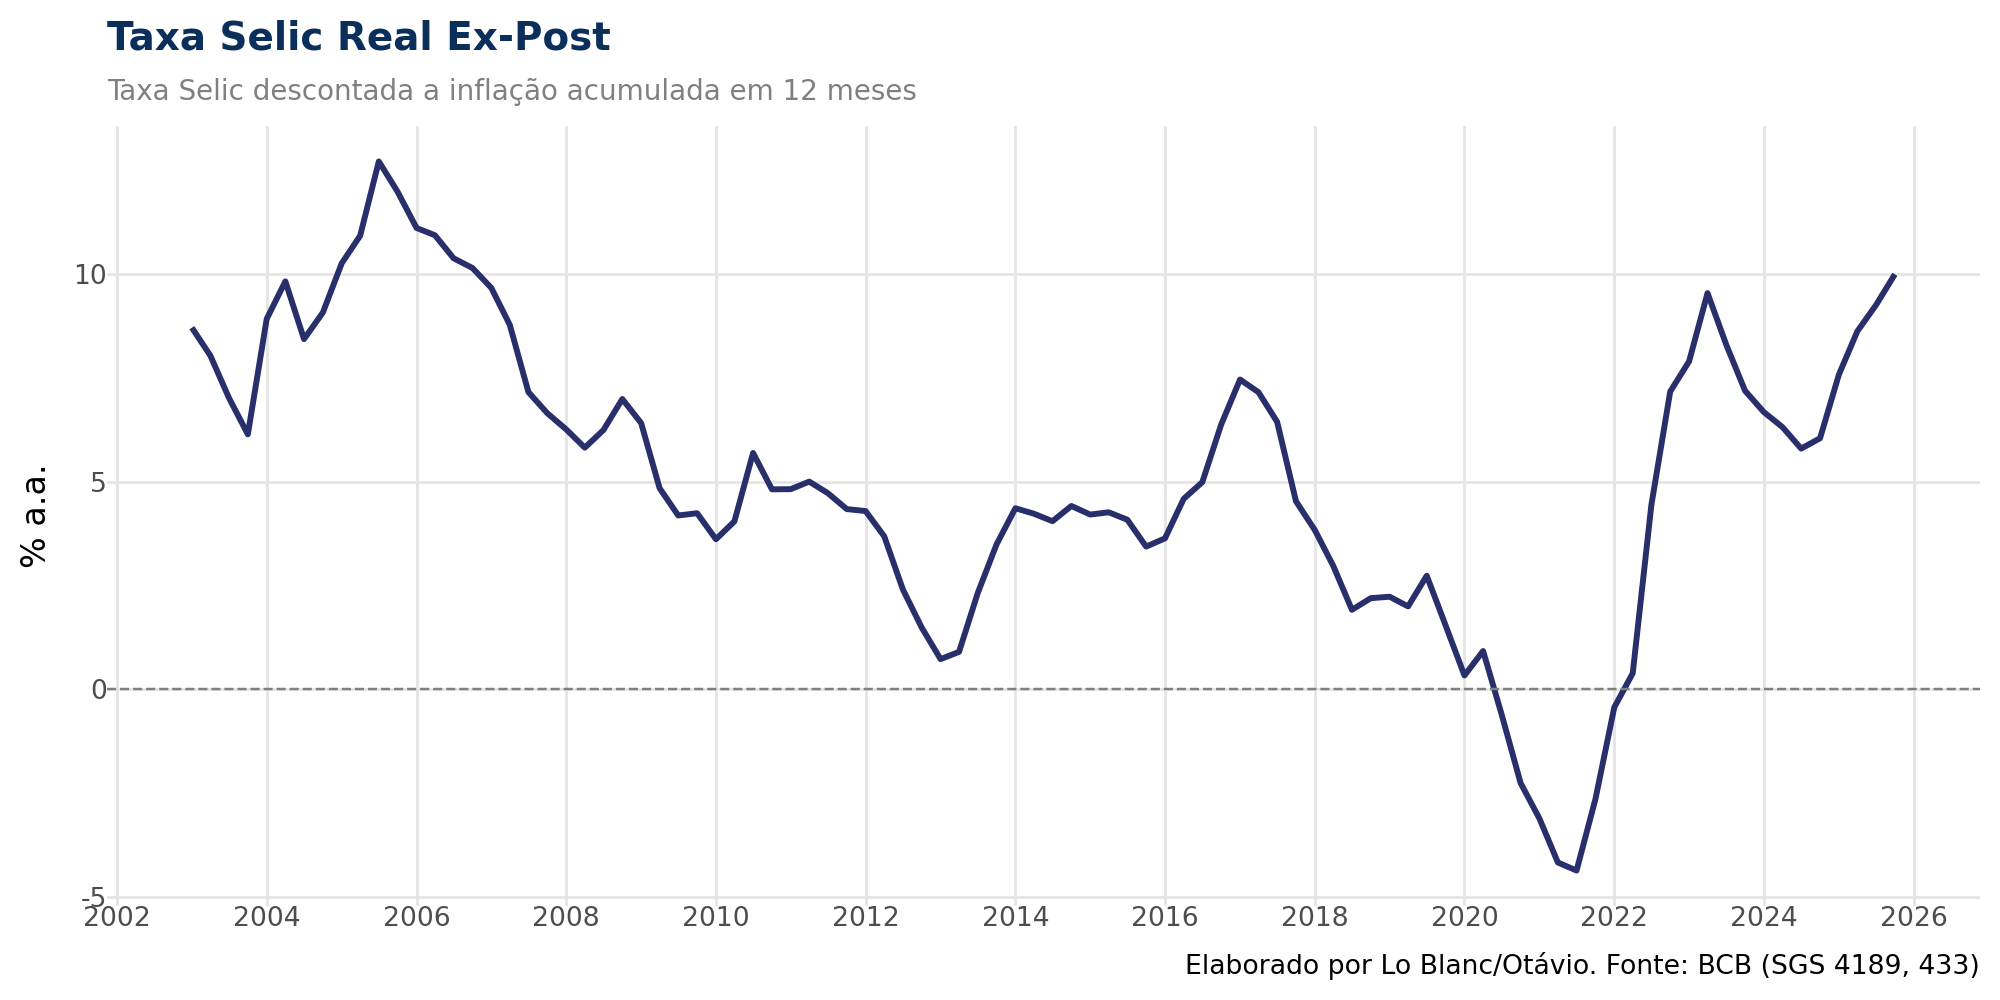

In [ ]:
g1 = (
    ggplot(df, aes(x='date', y='selic_real')) +
    geom_line(color=cores_am[0], size=1.2) +
    geom_hline(yintercept=0, linetype='dashed', color='grey', size=0.5) +
    scale_x_date(date_breaks='2 years', date_labels='%Y') +
    labs(
        title='Taxa Selic Real Ex-Post',
        subtitle='Taxa Selic descontada a inflação acumulada em 12 meses',
        x='',
        y='% a.a.',
        caption='Elaborado por Lo Blanc/Otávio. Fonte: BCB (SGS 4189, 433)'
    ) +
    theme_minimal(base_family='sans', base_size=12) +
    theme(
        plot_title=element_text(face='bold', size=14, color='#0A2F5B'),
        plot_subtitle=element_text(size=10, color='grey'),
        panel_grid_minor=element_blank(),
        figure_size=(10, 5)
    )
)

g1

### Renda Disponível das Famílias

A **renda disponível das famílias** apresenta uma trajetória de crescimento no longo prazo, interrompida pela recessão de 2015–2016, seguida por um período de relativa estabilidade, sem tendência bem definida, até o final da pandemia. A partir de 2022, observa-se uma aceleração do crescimento, com a renda retomando uma trajetória claramente ascendente. Em termos econômicos, espera-se que aumentos na renda disponível estejam associados à expansão do consumo de bens, enquanto retrações da renda tendem a produzir o efeito oposto.


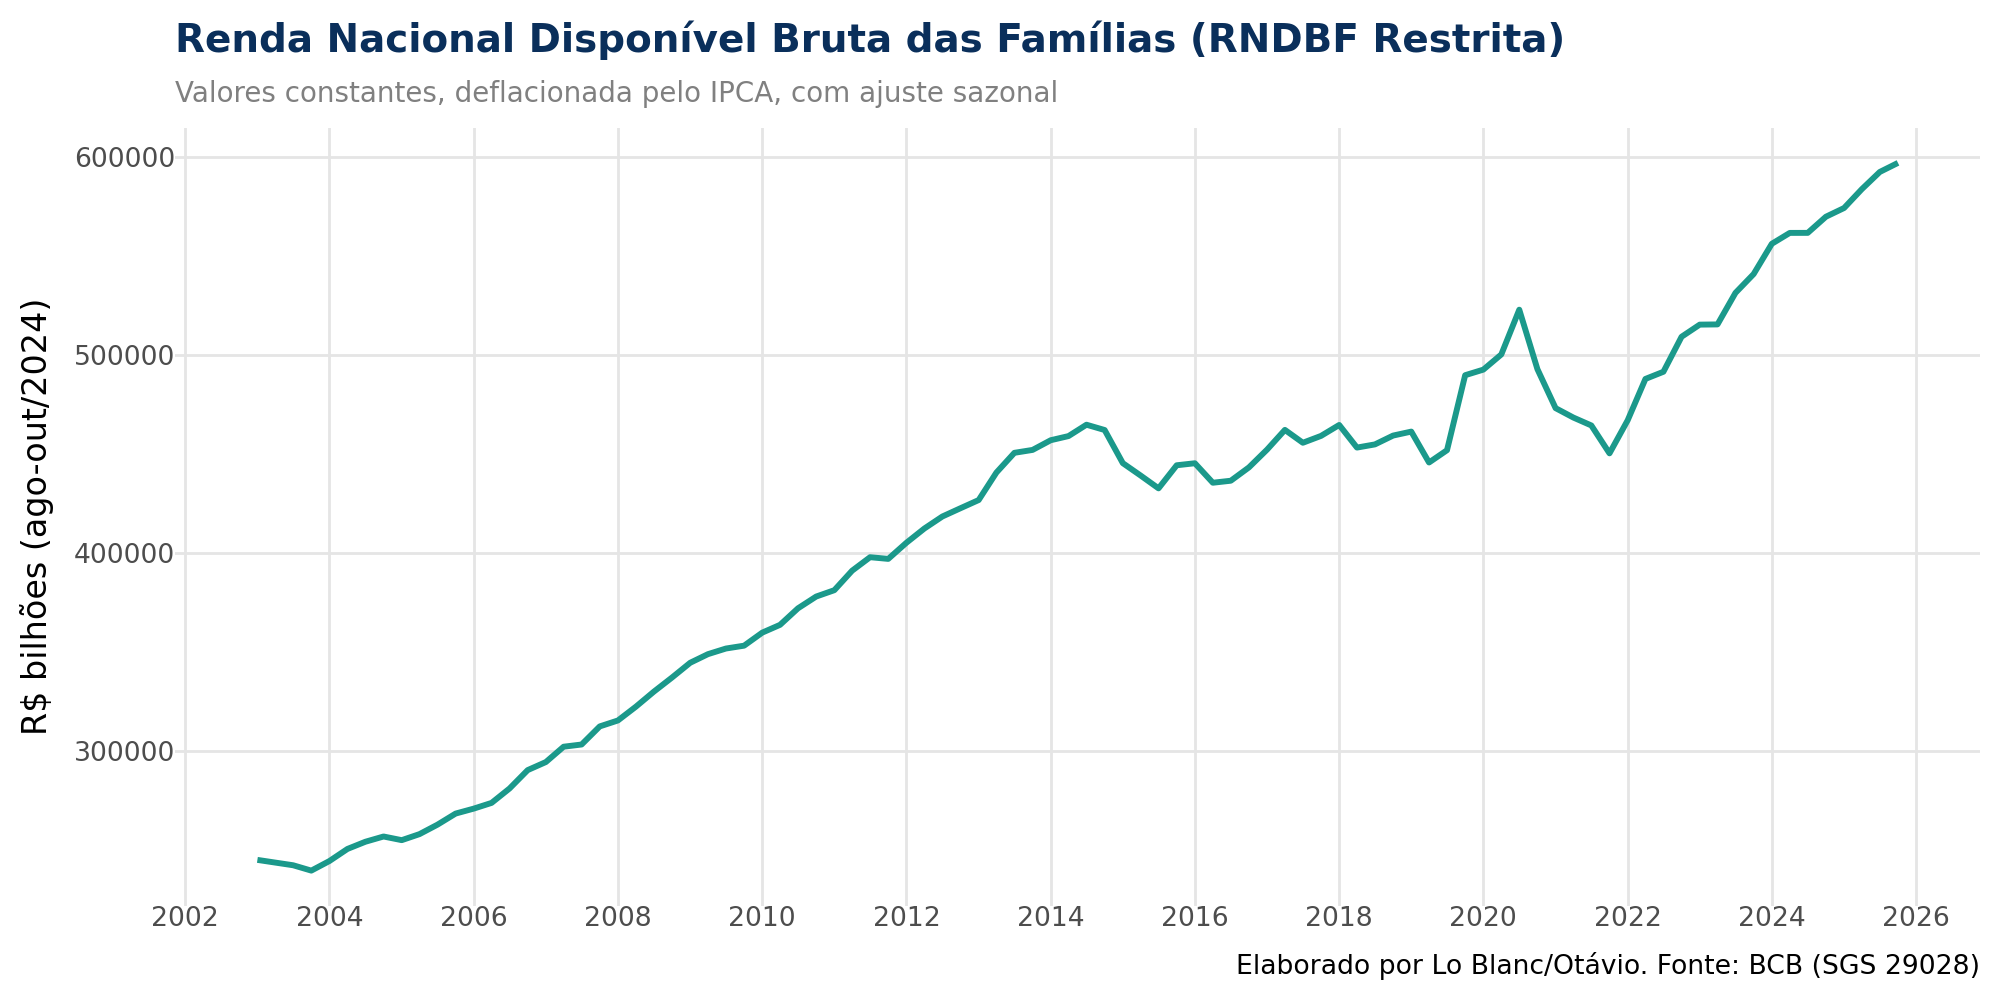

In [ ]:
g2 = (
    ggplot(df, aes(x='date', y='renda')) +
    geom_line(color=cores_am[1], size=1.2) +
    scale_x_date(date_breaks='2 years', date_labels='%Y') +
    labs(
        title='Renda Nacional Disponível Bruta das Famílias (RNDBF Restrita)',
        subtitle='Valores constantes, deflacionada pelo IPCA, com ajuste sazonal',
        x='',
        y='R$ bilhões (ago-out/2024)',
        caption='Elaborado por Lo Blanc/Otávio. Fonte: BCB (SGS 29028)'
    ) +
    theme_minimal(base_family='sans', base_size=12) +
    theme(
        plot_title=element_text(face='bold', size=14, color='#0A2F5B'),
        plot_subtitle=element_text(size=10, color='grey'),
        panel_grid_minor=element_blank(),
        figure_size=(10, 5)
    )
)

g2

### PMC

A comparação do consumo evidencia que o volume de vendas de **bens duráveis** é significativamente mais volátil e fortemente pró-cíclico do que o de **bens não duráveis**, os quais apresentam maior resiliência durante períodos de contração econômica.

Ambas as séries exibem trajetória ascendente até 2015, seguida por uma queda acentuada e posterior estabilização. Na parte final da amostra, observa-se um leve aumento no consumo de bens duráveis, enquanto os bens não duráveis permanece estável.

**Observação:** no exercício do *box* do Banco Central do Brasil (BCB), os resultados diferem do gráfico apresentado neste trabalho. Essa divergência decorre, em grande medida, da ausência de detalhamento sobre a fórmula de agregação dos itens no estudo original. Neste exercício, a construção do indicador foi realizada por meio de uma média simples dos itens selecionados.


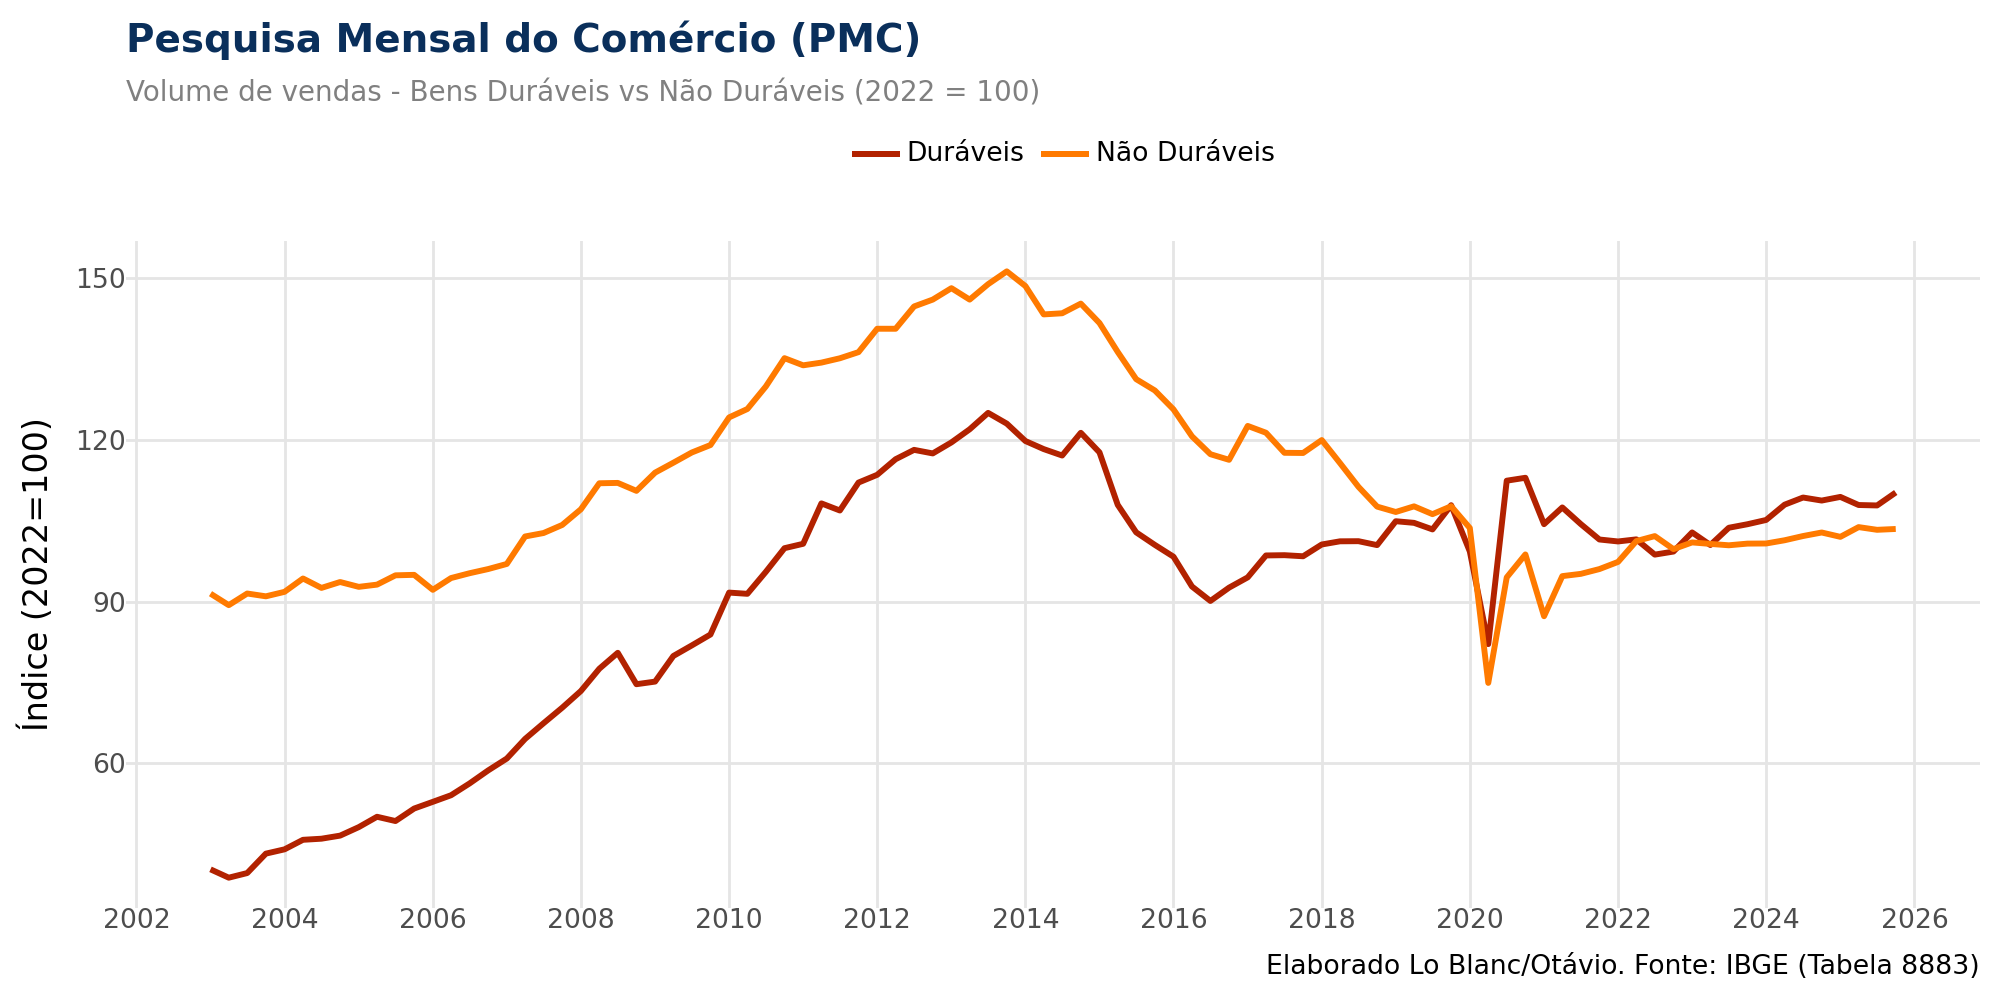

In [ ]:
# Prepara dados para gráfico comparativo
df_pmc_plot = pd.concat([
    df[['date', 'duraveis']].assign(tipo='Duráveis'),
    df[['date', 'nao_duraveis']].rename(columns={'nao_duraveis': 'duraveis'}).assign(tipo='Não Duráveis')
])

g3 = (
    ggplot(df_pmc_plot, aes(x='date', y='duraveis', color='tipo')) +
    geom_line(size=1.2) +
    scale_color_manual(
        values={
            'Duráveis': cores_am[4],
            'Não Duráveis': cores_am[2]
        }
    ) +
    scale_x_date(date_breaks='2 years', date_labels='%Y') +
    labs(
        title='Pesquisa Mensal do Comércio (PMC)',
        subtitle='Volume de vendas - Bens Duráveis vs Não Duráveis (2022 = 100)',
        x='',
        y='Índice (2022=100)',
        color='',
        caption='Elaborado Lo Blanc/Otávio. Fonte: IBGE (Tabela 8883)'
    ) +
    theme_minimal(base_family='sans', base_size=12) +
    theme(
        plot_title=element_text(face='bold', size=14, color='#0A2F5B'),
        plot_subtitle=element_text(size=10, color='grey'),
        legend_position='top',
        panel_grid_minor=element_blank(),
        figure_size=(10, 5)
    )
)

g3

# Modelagem

In [ ]:
# DF para Modelo VAR
df_model = (
    df
    .assign(
        # Δ Selic Real: variação da taxa de juros real
        d_selic=lambda x: x['selic_real'].diff(),
        # Δ log(Renda): taxa de crescimento da renda
        d_log_renda=lambda x: np.log(x['renda']).diff(),
        # Δ log(Não Duráveis): taxa de crescimento de não duráveis
        d_log_nao_duraveis=lambda x: np.log(x['nao_duraveis']).diff(),
        # Δ log(Duráveis): taxa de crescimento de duráveis
        d_log_duraveis=lambda x: np.log(x['duraveis']).diff(),
        # Adiciona dummy para pandemia
        dummy_pandemia=lambda x: ((x['date'] >= '2020-01-01') & (x['date'] <= '2021-12-31')).astype(int)
    )
    .dropna()  # Remove primeira observação (NA devido à diferenciação)
    .loc[:, ['date', 'd_selic', 'd_log_renda', 'd_log_nao_duraveis', 'd_log_duraveis', "dummy_pandemia"]]
    .reset_index(drop=True)
)

In [ ]:
# Dados do VAR: juros, renda, não duráveis, duráveis
var_data = df_model[['d_selic', 'd_log_renda', 'd_log_nao_duraveis', 'd_log_duraveis']]

# Variáveis exógenas (dummies)
exog = df_model[['dummy_pandemia']].values

# Modelo
model = VAR(var_data, exog = exog)

# Seleciona defasagens
lag_order = model.select_order(maxlags=8)

# Estima
results = model.fit(maxlags=lag_order.bic, trend="n")

# IRF
irf = results.irf(12)

## Funções de Impulso-Resposta a um Choque de Política Monetária

As IRFs para um choque positivo na taxa de juros real (um aperto monetário) revelam a potência e a seletividade do canal do crédito. A resposta do consumo de **Bens Não Duráveis** ao choque de juros é estatisticamente pouco significativa, com uma leve queda que rapidamente se dissipa. Este resultado é esperado, pois o consumo essencial é menos dependente de financiamento e mais atrelado à necessidade corrente.

Em forte contraste, o consumo de **Bens Duráveis** reage de forma acentuada e persistente. O choque de juros provoca uma queda imediata, estatisticamente significante e que se aprofunda por vários trimestres. Isso confirma que a política monetária afeta a demanda agregada primariamente ao encarecer o crédito e ao gerar incerteza, levando os consumidores a postergar a compra de itens de alto valor, que são tipicamente financiados.

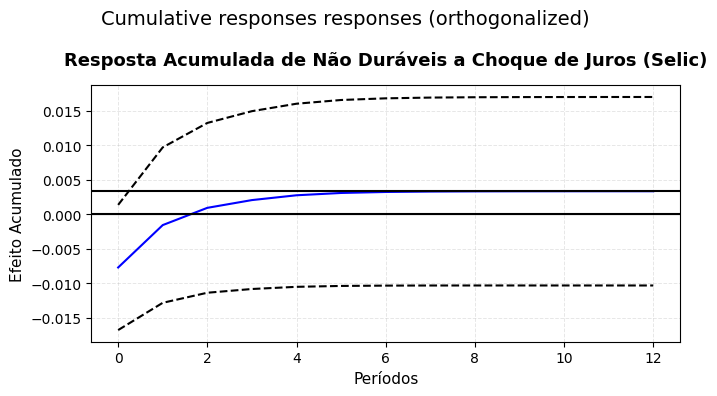

In [ ]:
# ===== GRÁFICO 1: Não Duráveis =====
irf.plot_cum_effects(
    impulse='d_selic',
    response='d_log_nao_duraveis',
    orth=True,
    figsize=(7, 4)
)

ax = plt.gca()
ax.set_title('Resposta Acumulada de Não Duráveis a Choque de Juros (Selic)',
             fontweight='bold', pad=15)
ax.set_xlabel('Períodos', fontsize=11)
ax.set_ylabel('Efeito Acumulado', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.7)

plt.tight_layout()
plt.show()

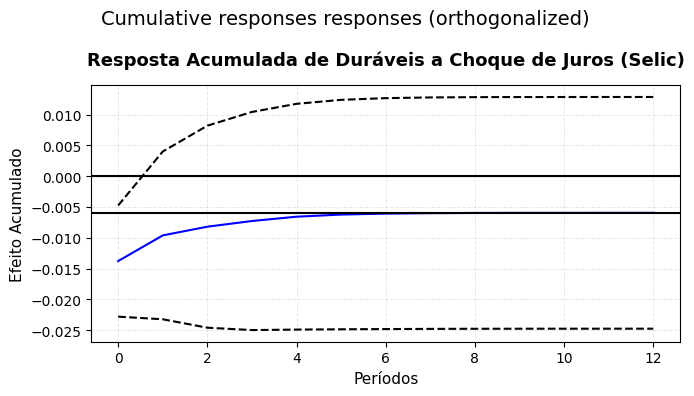

In [ ]:
# ===== GRÁFICO 2: Duráveis =====
irf.plot_cum_effects(
    impulse='d_selic',
    response='d_log_duraveis',
    orth=True,
    figsize=(7, 4)
)

ax = plt.gca()
ax.set_title('Resposta Acumulada de Duráveis a Choque de Juros (Selic)',
             fontweight='bold', pad=15)
ax.set_xlabel('Períodos', fontsize=11)
ax.set_ylabel('Efeito Acumulado', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.7)

plt.tight_layout()
plt.show()

## **Funções de Impulso-Resposta a um Choque de Renda**

As respostas a um choque positivo na renda disponível das famílias também são heterogêneas. O consumo de **Bens Não Duráveis** reage positivamente e de forma imediata, como previsto pela teoria da renda permanente, mas o efeito tende a se estabilizar rapidamente.

Já o consumo de **Bens Duráveis** exibe uma elasticidade-renda superior. A resposta ao choque de renda é positiva, robusta e mais persistente, indicando que um aumento na renda disponível não apenas eleva o consumo corrente, mas também viabiliza decisões de compra de maior valor que haviam sido postergadas.


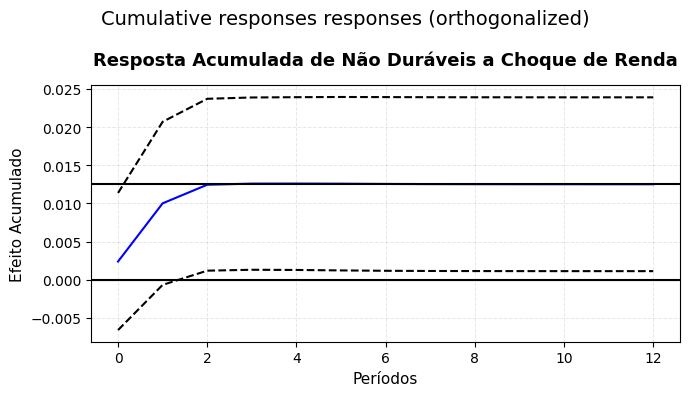

In [ ]:
# ===== GRÁFICO 1: Não Duráveis =====
irf.plot_cum_effects(
    impulse='d_log_renda',
    response='d_log_nao_duraveis',
    orth=True,
    figsize=(7, 4)
)

ax = plt.gca()
ax.set_title('Resposta Acumulada de Não Duráveis a Choque de Renda',
             fontweight='bold', pad=15)
ax.set_xlabel('Períodos', fontsize=11)
ax.set_ylabel('Efeito Acumulado', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.7)

plt.tight_layout()
plt.show()


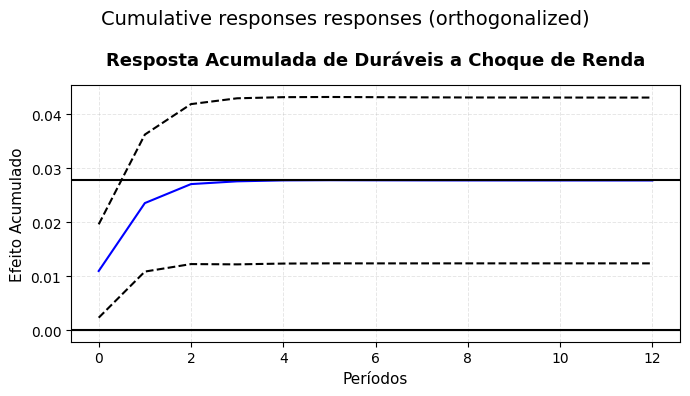

In [ ]:
# ===== GRÁFICO 2: Duráveis =====
irf.plot_cum_effects(
    impulse='d_log_renda',
    response='d_log_duraveis',
    orth=True,
    figsize=(7, 4)
)

ax = plt.gca()
ax.set_title('Resposta Acumulada de Duráveis a Choque de Renda',
             fontweight='bold', pad=15)
ax.set_xlabel('Períodos', fontsize=11)
ax.set_ylabel('Efeito Acumulado', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.7)

plt.tight_layout()
plt.show()

## Conclusão

A análise econométrica realizada neste exercício, viabilizada integralmente pelo ecossistema Python, confirma com robustez as hipóteses teóricas sobre o comportamento do consumo no Brasil. Os resultados demonstram que o consumo de bens duráveis é o principal canal de transmissão da política monetária para a economia real, dada sua alta sensibilidade às condições de crédito e ao custo de capital. Da mesma forma, sua elevada elasticidade-renda o torna um importante amplificador dos ciclos econômicos.

Este estudo exemplifica como a combinação de teoria econômica, dados públicos e ferramentas computacionais modernas permite aprofundar a compreensão de fenômenos macroeconômicos complexos. A capacidade do Python de automatizar a coleta, o tratamento e a modelagem de dados posiciona a linguagem como uma ferramenta indispensável para a pesquisa econômica contemporânea, permitindo análises detalhadas e reprodutíveis que informam tanto o debate acadêmico quanto a tomada de decisão de política econômica.

## Referências

BANCO CENTRAL DO BRASIL. Boxe 3: Consumo de bens duráveis e não duráveis. In: Relatório de Inflação: dezembro 2024. Brasília: BCB, 2024. p. 43-46. Disponível em: https://www.bcb.gov.br/content/ri/relatorioinflacao/202412/ri202412b3p.pdf. Acesso em: 08 jan. 2026.